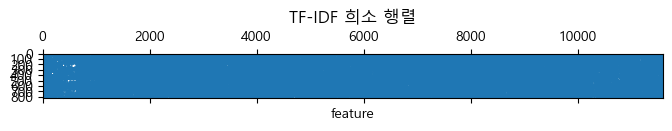

In [8]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
import joblib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.style.use('default')

font_location = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname = font_location).get_name()
matplotlib.rc('font',family = font_name)


# 데이터 불러오기
os.chdir('C:/Users/USER/Desktop/핵심역량 프로젝트/데이터/라벨링 데이터')

data = pd.read_csv('0727_masking_labeling_data.csv')

selected_columns1 = ['text_morphed','title_morphed', 'aggr', '욕설_모욕', '비꼼_시비', '성희롱', '요지불명', '저격성 민원']
data1 = data[selected_columns1][data.aggr == 0]
data2 = data[selected_columns1][data.aggr == 1]
data1 = data1[300:812]
data2 = data2


data3 = pd.concat([data1, data2])
# 텍스트와 라벨 분리
data_contents = data3['text_morphed'] + ' ' + data3['title_morphed']
# 
# 원래의 'text_morphed_'와 'title' 컬럼 삭제
data_labeling = data3['aggr']


# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(data_contents, data_labeling, stratify=data_labeling, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)


plt.figure(figsize=(8, 8))  # 정사각형 박스 설정
plt.spy(X_train_tfidf, markersize=1)
plt.title('TF-IDF 희소 행렬')
plt.xlabel('feature')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

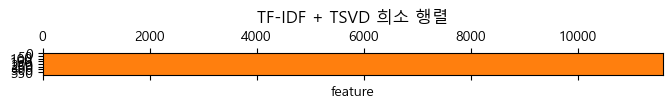

In [9]:

# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)

# TSVD 적용
n_components = 400  # 원하는 차원 수를 지정
tsvd = TruncatedSVD(n_components=n_components, random_state=42)
X_train_tsvd = tsvd.fit_transform(X_train_tfidf)

# TSVD 결과를 희소 행렬로 변환
X_train_tsvd_sparse = tsvd.components_

# 희소 행렬 시각화
plt.figure(figsize=(8, 8))  # 정사각형 박스 설정
plt.spy(X_train_tsvd_sparse, markersize=1,color = 'tab:orange')
plt.title('TF-IDF + TSVD 희소 행렬')
plt.xlabel('feature')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [20]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.decomposition import TruncatedSVD

font_location = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname = font_location).get_name()
matplotlib.rc('font',family = font_name)

# 데이터 불러오기
data_path = 'C:/Users/USER/Desktop/핵심역량 프로젝트/데이터/라벨링 데이터/0727_masking_labeling_data.csv'
data = pd.read_csv(data_path)

selected_columns = ['text_morphed', 'title_morphed', 'aggr']
data = data[selected_columns]

# 데이터 필터링
data1 = data[data['aggr'] == 0].iloc[300:812]
data2 = data[data['aggr'] == 1]
data3 = pd.concat([data1, data2])

# 텍스트와 라벨 분리
data_contents = data3['text_morphed'] + ' ' + data3['title_morphed']
data_labeling = data3['aggr']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(data_contents, data_labeling, stratify=data_labeling, test_size=0.2, random_state=42)

# TSVD 적용 여부에 따른 파이프라인 정의
def create_pipelines(apply_tsvd=False):
    pipelines = {}

    # 선택한 벡터라이저
    vectorizer = TfidfVectorizer()
    tsvd = TruncatedSVD(n_components=400, random_state=42) if apply_tsvd else None

    for name, model in [
        ('extra_trees', ExtraTreesClassifier()),
        ('ridge_classifier', RidgeClassifier()),
        ('logistic_regression', LogisticRegression()),
        ('svm', SVC(probability=True)),
        ('hard_model', VotingClassifier([
            ('LR', LogisticRegression()), 
            ('ridge', RidgeClassifier()), 
            ('svm', SVC()), 
            ('et', ExtraTreesClassifier())], voting='hard')),
        ('soft_model', VotingClassifier([
            ('LR', LogisticRegression()), 
            ('svm', SVC(probability=True)), 
            ('et', ExtraTreesClassifier())], voting='soft'))
    ]:
        steps = [('vect', vectorizer)]
        if tsvd:
            steps.append(('tsvd', tsvd))
        steps.append((name, model))
        pipelines[name] = Pipeline(steps)
    
    return pipelines

# 두 가지 파이프라인 세트 생성
pipelines_no_tsvd = create_pipelines(apply_tsvd=False)
pipelines_tsvd = create_pipelines(apply_tsvd=True)

# 모델 훈련 및 평가
results = {'no_tsvd': {}, 'tsvd': {}}

def train_and_evaluate(pipelines, key):
    for model_name, pipeline in pipelines.items():
        print(f"{key} - Training {model_name}...")

        # 모델 훈련
        pipeline.fit(X_train, y_train)
        
        # 교차검증 점수 계산
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
        
        # 성능 출력 및 저장
        train_score = pipeline.score(X_train, y_train)
        test_score = pipeline.score(X_test, y_test)
        results[key][model_name] = {
            'train_score': train_score,
            'test_score': test_score,
            'cv_scores': cv_scores,
            'cv_mean': cv_scores.mean()
        }

        print(f"{model_name} 훈련 세트 점수: {train_score:.4f}")
        print(f"{model_name} 테스트 세트 점수: {test_score:.4f}")
        print(f"{model_name} 교차검증 평균 점수: {cv_scores.mean():.4f}\n")

        # 모델 저장
        model_save_path = os.path.join(f'C:/Users/USER/Desktop/핵심역량 프로젝트/데이터/모델/0727_aggr_{model_name}_tfidf_{"tsvd_" if key == "tsvd" else ""}nonemasking_model.pkl')
        joblib.dump(pipeline, model_save_path)

train_and_evaluate(pipelines_no_tsvd, 'no_tsvd')
train_and_evaluate(pipelines_tsvd, 'tsvd')

# 성능 비교 시각화
def plot_performance_comparison(results):
    model_names = list(results['no_tsvd'].keys())
    no_tsvd_scores = [results['no_tsvd'][name]['test_score'] for name in model_names]
    tsvd_scores = [results['tsvd'][name]['test_score'] for name in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 8))
    bars1 = ax.bar(x - width/2, no_tsvd_scores, width, label='No TSVD')
    bars2 = ax.bar(x + width/2, tsvd_scores, width, label='TSVD')

    ax.set_xlabel('모델')
    ax.set_ylabel('정확도')
    ax.set_title('TSVD 적용 전후 모델 성능 비교')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=0, ha='right')
    ax.legend()

    for bars in [bars1, bars2]:
        ax.bar_label(bars, fmt='%.4f', padding=3)

    plt.tight_layout()
    plt.show()

plot_performance_comparison(results)




no_tsvd - Training extra_trees...


KeyboardInterrupt: 